# Import Necessary Libraries

In [93]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast, RandomCrop, Resize, Compose
)
from albumentations.pytorch import ToTensorV2
import json
import random
from PIL import ImageFilter
from PIL import ImageOps
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.rpn import AnchorGenerator
import torch


# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from vision.references.detection.engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [94]:
from Augmentations import *
from Collector import *
from ExtractBoxesandLabels import *
from DatasetCreator import *
from Categories_info import *
from BasedSupervisedModel import *

# Define Dataset Class

In [ ]:
os.getcwd()

In [96]:
def Collect_Image_Location_and_Labels_Info(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    daytime_image_folders=[]
    labels_of_images=[]
    for k in json_data:
        if k['attributes']['timeofday']=='daytime':
            daytime_image_folders.append(k['name'])
            labels_of_images.append(k['labels'])
    return daytime_image_folders,labels_of_images

In [ ]:
train_json_path='../Datasets/bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json'
train_image_path='../Datasets/bdd100k/bdd100k/bdd100k/images/100k/train/'
val_json_path='../Datasets/bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json'
val_image_path='../Datasets/bdd100k/bdd100k/bdd100k/images/100k/val/'
daytime_image_paths_train,labels_of_images_train=Collect_Image_Location_and_Labels_Info(train_json_path)
daytime_image_paths_val,labels_of_images_val=Collect_Image_Location_and_Labels_Info(val_json_path)

In [6]:
def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets

In [7]:
import torch 
import torch
from torch.utils.data import DataLoader, random_split

val_augmentations = build_strong_augmentation(False)
BATCH_SIZE=4
train_dataset=bdd100kDataset(image_dir=train_image_path,image_files=daytime_image_paths_train, labels_of_image=labels_of_images_train,instance_classes= instance_classes,class_to_category= class_to_category,category_map=category_map, transform=val_augmentations)

num_samples = len(train_dataset)
subset_1k_size = 1000
subset_9k_size = num_samples - subset_1k_size
subset_1k, subset_9k = random_split(train_dataset, [subset_1k_size, subset_9k_size])
bdd100k_train_loader = DataLoader(subset_1k, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)

val_dataset=bdd100kDataset(image_dir=val_image_path,image_files=daytime_image_paths_val, labels_of_image=labels_of_images_val,instance_classes= instance_classes,class_to_category= class_to_category,category_map=category_map, transform=val_augmentations)
num_samples = len(val_dataset)
subset_1k_size = 500
subset_9k_size = num_samples - subset_1k_size
subset_1k, subset_9k = random_split(val_dataset, [subset_1k_size, subset_9k_size])
bdd100k_val_loader = DataLoader(subset_1k, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)

In [31]:
def save_preprocessed_data(loader, preprocessed_dir):
    
    os.makedirs(preprocessed_dir, exist_ok=True)

    for idx, (images, targets) in enumerate(loader):
        # Define file paths
        image_file = os.path.join(preprocessed_dir, f"image_{idx}.pt")
        target_file = os.path.join(preprocessed_dir, f"target_{idx}.pt")
        
        # Save images directly as PyTorch tensors
        torch.save(images, image_file)

        # Save targets as a list of dictionaries
        torch.save(targets, target_file)

    print(f"Saved preprocessed data to {preprocessed_dir}")

preprocessed_dir_val = "BDD100k_Preprocessed_Val_Data"
preprocessed_dir_train = "BDD100k_Preprocessed_Train_Data"
if not os.path.exists(f'./{preprocessed_dir_val}'):
    save_preprocessed_data(bdd100k_val_loader, preprocessed_dir_val)

if not os.path.exists(f'./{preprocessed_dir_train}'):
    save_preprocessed_data(bdd100k_train_loader, preprocessed_dir_train)


class PreprocessedDataset(Dataset):
    def __init__(self, preprocessed_dir):
        self.preprocessed_dir = preprocessed_dir
        self.image_files = sorted([f for f in os.listdir(preprocessed_dir) if f.startswith("image_") and f.endswith(".pt")])
        self.target_files = sorted([f for f in os.listdir(preprocessed_dir) if f.startswith("target_") and f.endswith(".pt")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.preprocessed_dir, self.image_files[idx])
        target_file = os.path.join(self.preprocessed_dir, self.target_files[idx])
        images = torch.load(image_file)  
        targets = torch.load(target_file) 
        return images, targets

dataset = PreprocessedDataset(preprocessed_dir_val)
bdd100k_val_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x[0]) 
dataset = PreprocessedDataset(preprocessed_dir_train)
bdd100k_train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x[0])

In [9]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

val_augmentations = build_strong_augmentation(False)
val_image_dir = "../Datasets/SIM10k/VOC2012/JPEGImages/"
val_dataset=Sim10kDataset(val_image_dir,transform=val_augmentations)
BATCH_SIZE=4
num_samples = len(val_dataset)
subset_1k_size = 500
subset_2k_size = 1000
subset_9k_size = num_samples - subset_1k_size-subset_2k_size
subset_1k,subset_2k, subset_9k = random_split(val_dataset, [subset_1k_size,subset_2k_size, subset_9k_size])

val_loader = DataLoader(subset_1k, batch_size=BATCH_SIZE, shuffle=True)
train_loader=DataLoader(subset_2k, batch_size=BATCH_SIZE, shuffle=True)
def save_preprocessed_data(loader, preprocessed_dir):
    
    os.makedirs(preprocessed_dir, exist_ok=True)

    for idx, images in enumerate(loader):
        # Define file paths
        image_file = os.path.join(preprocessed_dir, f"image_{idx}.pt")

        
        # Save images directly as PyTorch tensors
        torch.save(images, image_file)

    print(f"Saved preprocessed data to {preprocessed_dir}")

preprocessed_dir_val = "Sim10k_Preprocessed_Val_Data"
preprocessed_dir_train = "Sim10k_Preprocessed_Train_Data"
if not os.path.exists(f'./{preprocessed_dir_val}'):
    save_preprocessed_data(val_loader, preprocessed_dir_val)
if not os.path.exists(f'./{preprocessed_dir_train}'):
    save_preprocessed_data(train_loader, preprocessed_dir_train)

class PreprocessedDataset(Dataset):
    def __init__(self, preprocessed_dir):
        self.preprocessed_dir = preprocessed_dir
        self.image_files = sorted([f for f in os.listdir(preprocessed_dir) if f.startswith("image_") and f.endswith(".pt")])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.preprocessed_dir, self.image_files[idx])

        images = torch.load(image_file)  
        return images
dataset = PreprocessedDataset(preprocessed_dir_val)
sim10k_val_loader = DataLoader(dataset, batch_size=1, shuffle=True) 
dataset = PreprocessedDataset(preprocessed_dir_train)
sim10k_train_loader = DataLoader(dataset, batch_size=1, shuffle=True) 

In [10]:


train_image_dir = "../Datasets/leftImg8bit/train/all_data"
train_instance_dir = "../Datasets/gtFine/train/all_data"
val_image_dir = "../Datasets/leftImg8bit/val/all_data"
val_instance_dir = "../Datasets/gtFine/val/all_data"
train_augmentations = build_strong_augmentation(True)
val_augmentations = build_strong_augmentation(False)
BATCH_SIZE=4

train_dataset = CityscapesBBoxDataset(
    image_dir=train_image_dir,
    instance_dir=train_instance_dir,
    json_dir=train_instance_dir,
    instance_classes=instance_classes,
    class_to_category=class_to_category,
    category_map=category_map,
    transform=train_augmentations
)
num_samples = len(train_dataset)
subset_1k_size = 1000
subset_9k_size = num_samples - subset_1k_size
subset_1k, subset_9k = random_split(train_dataset, [subset_1k_size, subset_9k_size])
train_loader = DataLoader(subset_1k, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)
val_dataset = CityscapesBBoxDataset(
    image_dir=val_image_dir,
    instance_dir=val_instance_dir,
    json_dir=val_instance_dir,
    instance_classes=instance_classes,
    class_to_category=class_to_category,
    category_map=category_map,
    transform=val_augmentations
)
num_samples = len(val_dataset)
subset_1k_size = 500
subset_9k_size = num_samples - subset_1k_size
subset_1k, subset_9k = random_split(val_dataset, [subset_1k_size, subset_9k_size])
val_loader = DataLoader(subset_1k, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)

def save_preprocessed_data(loader, preprocessed_dir):
    
    os.makedirs(preprocessed_dir, exist_ok=True)

    for idx, (images, targets) in enumerate(loader):
        # Define file paths
        image_file = os.path.join(preprocessed_dir, f"image_{idx}.pt")
        target_file = os.path.join(preprocessed_dir, f"target_{idx}.pt")
        
        # Save images directly as PyTorch tensors
        torch.save(images, image_file)

        # Save targets as a list of dictionaries
        torch.save(targets, target_file)

    print(f"Saved preprocessed data to {preprocessed_dir}")

preprocessed_dir_val = "CityScapes_Preprocessed_Val_Data"
preprocessed_dir_train = "CityScapes_Preprocessed_Train_Data"
if not os.path.exists(f'./{preprocessed_dir_val}'):
    save_preprocessed_data(val_loader, preprocessed_dir_val)

if not os.path.exists(f'./{preprocessed_dir_train}'):
    save_preprocessed_data(train_loader, preprocessed_dir_train)


class PreprocessedDataset(Dataset):
    def __init__(self, preprocessed_dir):
        self.preprocessed_dir = preprocessed_dir
        self.image_files = sorted([f for f in os.listdir(preprocessed_dir) if f.startswith("image_") and f.endswith(".pt")])
        self.target_files = sorted([f for f in os.listdir(preprocessed_dir) if f.startswith("target_") and f.endswith(".pt")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.preprocessed_dir, self.image_files[idx])
        target_file = os.path.join(self.preprocessed_dir, self.target_files[idx])
        images = torch.load(image_file)  
        targets = torch.load(target_file) 
        return images, targets

dataset = PreprocessedDataset(preprocessed_dir_val)
cityscapes_val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: x[0]) 
dataset = PreprocessedDataset(preprocessed_dir_train)
cityscapes_train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: x[0])

In [ ]:
for image, target in cityscapes_train_loader:
    print("Target:", target)
    break

Target: ({'boxes': tensor([[1048.2422,  244.9219, 1112.1094,  308.2031],
        [   0.0000,    0.0000, 1199.4141,  234.9609],
        [   0.0000,    0.0000, 1199.4141,  599.4141],
        [   0.0000,  302.3438, 1199.4141,  599.4141],
        [   0.0000,  286.5234,  827.3438,  599.4141],
        [ 128.3203,  246.0938,  178.1250,  262.5000],
        [ 953.9062,  324.0234, 1199.4141,  547.8516],
        [   0.0000,  254.8828, 1199.4141,  445.8984],
        [ 109.5703,   30.4688,  516.2109,  261.3281],
        [ 380.8594,  231.4453,  388.4766,  254.2969],
        [ 363.8672,  234.3750,  411.9141,  260.1562],
        [1048.2422,  244.9219, 1112.1094,  308.2031],
        [ 315.2344,  233.7891,  338.6719,  259.5703],
        [ 332.8125,  240.2344,  366.7969,  258.3984],
        [ 271.2891,  225.5859,  283.0078,  261.9141],
        [ 275.9766,  234.9609,  308.7891,  270.7031],
        [ 280.0781,  222.0703,  306.4453,  266.6016],
        [ 291.2109,  204.4922,  331.0547,  292.9688],
        [

# Lets See Some Images and Their Labels

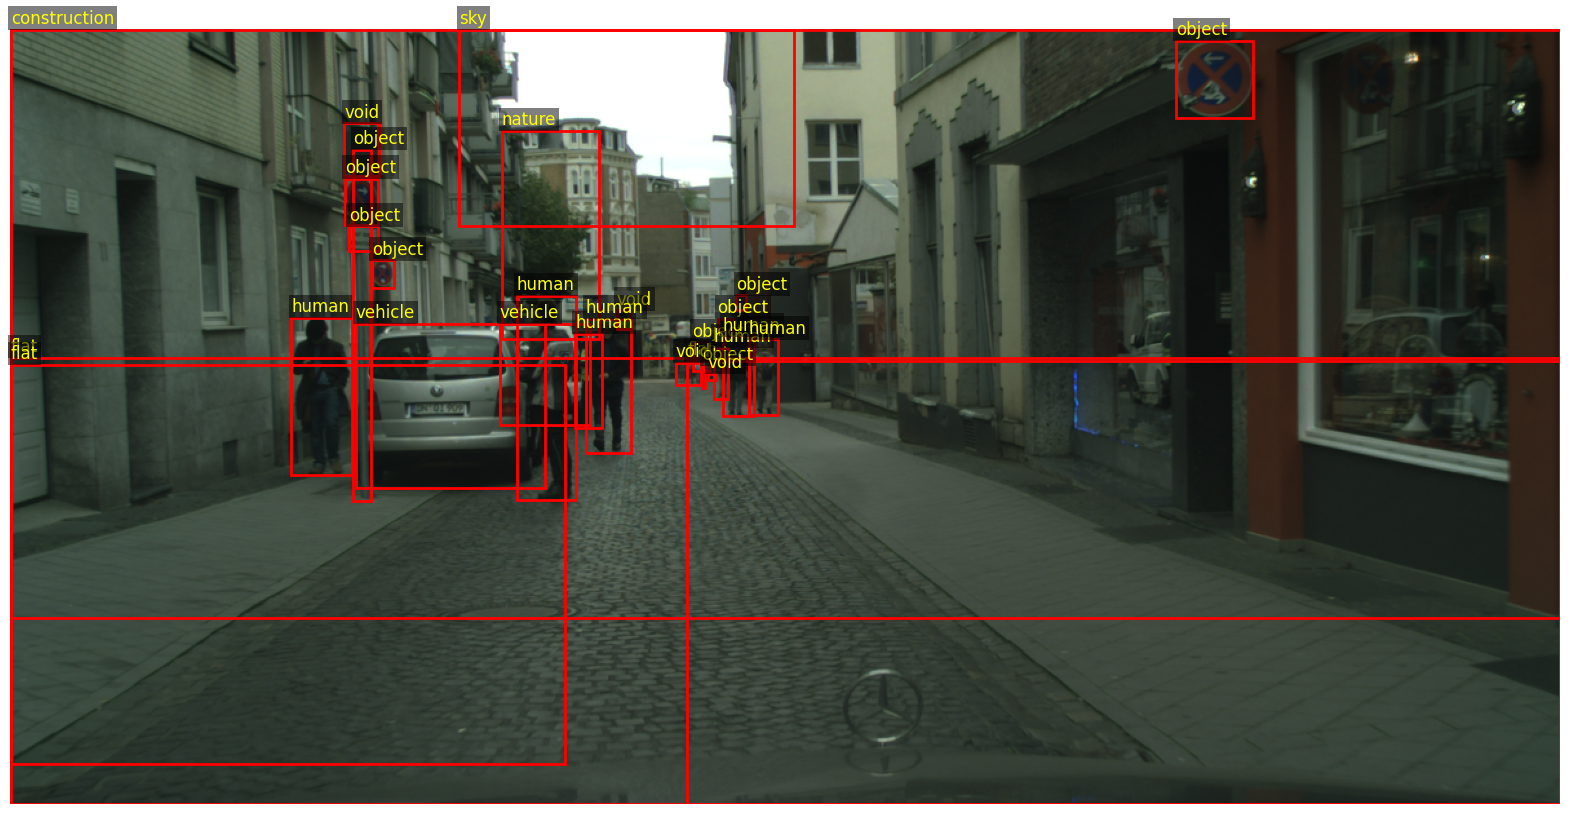

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch  # Ensure torch is imported if dealing with tensors
classes={0: 'flat',
 1: 'construction',
 2: 'nature',
 3: 'vehicle',
 4: 'sky',
 5: 'object',
 6: 'human',
 7: 'void'}
def plot_img_bbox(img, target):
    """
    Plots an image with bounding boxes and their associated labels.

    Args:
        img (np.ndarray or torch.Tensor): The image to plot.
        target (dict): Dictionary containing 'boxes' (list of [xmin, ymin, xmax, ymax]) and 'labels'.

    """
    # Convert the image from (C, H, W) to (H, W, C) if it's a PyTorch tensor
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    # Normalize the image values if they are not in the range [0, 1]
    if img.max() > 1:
        img = img / 255.0

    # Plot the image and bounding boxes
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(20, 20)
    a.imshow(img)

    # Iterate over bounding boxes and labels
    for box, label in zip(target['boxes'], target['labels']):
        # Extract box coordinates
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        a.add_patch(rect)  # Add the rectangle to the plot

        # Add label text above the bounding box
        a.text(
            x_min,
            y_min - 5,  # Slightly above the top-left corner
            str(classes[label.item()]),  # Convert label to string
            color='yellow',
            fontsize=12,
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2)  # Background for better visibility
        )

    plt.axis("off")  # Turn off axes
    plt.show()

img, target = train_dataset[23]
#print(img[0])
plot_img_bbox(img, target)

# Supervised Modelling Idea

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import logging


logging.basicConfig(
    filename='Model_Results/training.log', 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FasterRCNNModel(num_classes=8).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

if os.path.exists("./Model_Results/checkpoint.pth"):
    checkpoint = torch.load("./Model_Results/checkpoint.pth")
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch=0



num_epochs = 5  

train_losses = []
val_losses = []
logging.info("Training started.")
for epoch in range(start_epoch,start_epoch+num_epochs):
    logging.info("Training started.")
    logging.info(f"Epoch {epoch + 1}/{start_epoch + num_epochs}")
    print(f"\nEpoch {epoch + 1}/{start_epoch + num_epochs}")
    print("-" * 20)
    # Training phase
    model.train()
    train_loss = 0.0
    
    for i,(images, targets) in enumerate(tqdm(cityscapes_train_loader, desc="Training")):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        logging.info(str(loss_dict))
        losses = sum(loss for loss in loss_dict.values())
    
        train_loss += losses.item() 
                                # Backward pass
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()    

    avg_train_loss = train_loss / len(cityscapes_train_loader)
    logging.info(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)
    model.eval()
    logging.info("Validation evaluation started.")
    val_loss=0.0
    for i,(images, targets) in enumerate(tqdm(cityscapes_val_loader, desc="Validation")):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.train()
        
        
        with torch.no_grad(): 
            loss_dict = model(images, targets)
            logging.info(f"Validation Losses: {loss_dict}")  
            losses = sum(loss for loss in loss_dict.values())
            
            val_loss += losses.item() 

    avg_val_loss = val_loss / len(cityscapes_val_loader)
    logging.info(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)
    
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }, "./Model_Results/checkpoint.pth")
    if os.path.exists('Model_Results/Loses_info.csv'):
        pd.concat([pd.read_csv('Model_Results/Loses_info.csv'),pd.DataFrame({'Train Loss Value':train_losses,'Validation Loss Value':val_losses})]).to_csv('Model_Results/Loses_info.csv',index=False)
    else:
        pd.DataFrame({'Train Loss Value':train_losses,'Validation Loss Value':val_losses}).to_csv('Model_Results/Loses_info.csv',index=False)

logging.info(f"Training completed for all epochs !")
print(f"Training completed for all epochs !")


# Base Models and Need Functions

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.ops import MultiScaleRoIAlign

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x

    @staticmethod
    def backward(ctx, grad_output):

        return -grad_output


class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim=512):
        super(DomainDiscriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, 2),  
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        domain_logits = self.classifier(x)
        return domain_logits


class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()

        backbone = vgg16(pretrained=True).features
        backbone.out_channels = 512 

        anchor_generator = AnchorGenerator(
            sizes=((16,),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        self.box_roi_pool = MultiScaleRoIAlign(
            featmap_names=["0"],  
            output_size=(8, 8),   
            sampling_ratio=2
        )

        self.detection_head = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=self.box_roi_pool
        )
        self.backbone = backbone
        self.detection_head = self.detection_head
        self.roi_pool = self.box_roi_pool

    def forward(self, images, targets=None):
       
        if isinstance(images, list):
            images = torch.stack(images)
        
        features = self.detection_head.backbone(images)
        
        image_shapes = [img.shape[-2:] for img in images]
        
        if targets is None:
            return self.detection_head(images, targets=None)  
        outputs = self.detection_head.roi_heads(features, image_shapes, targets)
        
        return outputs


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()

        super().__init__()
        backbone = vgg16(pretrained=True).features
        backbone.out_channels = 600 

        anchor_generator = AnchorGenerator(
            sizes=((16,),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        self.box_roi_pool = MultiScaleRoIAlign(
            featmap_names=["0"], 
            output_size=(8, 8),  
            sampling_ratio=2
        )
        self.detection_head = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=self.box_roi_pool
        )
        self.backbone = backbone
        self.detection_head = self.detection_head
        self.roi_pool = self.box_roi_pool

    def forward(self, images, targets=None):
        if isinstance(images, list):
            images = torch.stack(images)
        features = self.backbone(images)

        # Detection head processes features and computes losses
        outputs = self.detection_head(features, targets)

        return outputs


In [116]:
def train_fnpm(fnpm, teacher_model, target_loader, optimizer_fnpm, fnpm_iterations):
    fnpm.train()
    total_loss = 0.0
    for iteration in range(fnpm_iterations):
        for images, _ in target_loader: 
            with torch.no_grad():
                pseudo_labels = teacher_model(images)
            
            optimizer_fnpm.zero_grad()
            loss = fnpm(images)
            loss.backward()
            optimizer_fnpm.step()
            
            total_loss += loss.item()
    
    return total_loss / fnpm_iterations


def active_sampling(fnpm, unsupervised_loader):
    fnpm.eval()
    selected_data = []

    with torch.no_grad():
        for images, _ in unsupervised_loader:
            uncertainty_scores = fnpm(images)
            
            for idx, score in enumerate(uncertainty_scores):
                if score.item() > 0.5:
                    selected_data.append((images[idx], score))
    
    return selected_data




def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area



from sklearn.metrics import average_precision_score

def compute_map(detections, annotations, iou_threshold=0.5):
    aps = []
    for det, ann in zip(detections, annotations):
        detected = [False] * len(det)
        true_positive = 0
        false_positive = 0
        for a in ann:
            matched = False
            for d in det:
                iou = compute_iou(d[:4], a)
                if iou >= iou_threshold:
                    true_positive += 1
                    matched = True
                    break
            if not matched:
                false_positive += 1
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / len(ann) if len(ann) > 0 else 0
        aps.append(precision * recall)
    
    return np.mean(aps)


# Implementation


In [ ]:
import numpy as np

def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def compute_map(detections, annotations, iou_threshold=0.5):
    aps = []

    for det, ann in zip(detections, annotations):
        detected = [False] * len(det['boxes'])  
        true_positive = 0
        false_positive = 0

        for i, gt in enumerate(ann['boxes']):
            matched = False
            for j, pred_box in enumerate(det['boxes']):
                iou = compute_iou(pred_box, gt)
                if iou >= iou_threshold:
                    if not detected[j]:
                        true_positive += 1
                        detected[j] = True
                        matched = True
                        break
            if not matched:
                false_positive += 1
        
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / len(ann['boxes']) if len(ann['boxes']) > 0 else 0
        
        ap = precision * recall
        aps.append(ap)

    return np.mean(aps)

In [136]:
avg_map_values=[]
adversarial_losses=[]
detection_losses=[]
total_losses=[]

In [138]:
batch_size = 4
num_iterations = 4
learning_rate = 0.02
lambda_adversarial = 0.01
momentum = 0.9
weight_decay = 1e-4
lr_steps = [30000, 35000]
active_sampling_steps = [5000, 10000, 15000, 20000, 25000]

fnpm_lr = 1e-4
fnpm_iterations = 2000
ema_alpha = 0.9996
adversarial_loss_weight = 0.01
iou_threshold = 0.5

grl = GradientReversalLayer.apply

class EMA:
    def __init__(self, model, alpha=0.9996):
        self.model = model
        self.alpha = alpha
        self.shadow = self._copy_params(model)

    def _copy_params(self, model):
        shadow = {}
        for name, param in model.named_parameters():
            shadow[name] = param.clone().detach()
        return shadow

    def update(self):
        
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                self.shadow[name] = self.alpha * self.shadow[name] + (1 - self.alpha) * param.detach()

    def apply(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param.copy_(self.shadow[name])

import torch
import torch.nn as nn
import torch.optim as optim

def train_student_model(train_loader, val_loader, target_loader, domain_discriminator, student_model, 
                        teacher_model, ema_model, num_iterations, lambda_adversarial=1.0, learning_rate=0.001):
    optimizer_student = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    optimizer_domain = optim.SGD(domain_discriminator.parameters(), lr=learning_rate, momentum=0.9)

    criterion_detection = nn.CrossEntropyLoss()  
    criterion_domain = nn.CrossEntropyLoss()     
    global_step = 0

    for iteration in range(num_iterations):
        source_iter = iter(train_loader)
        target_iter = iter(target_loader)
        source_images, source_targets = next(source_iter)
        target_images, _ = next(target_iter)
        
        source_images_tensor = torch.stack(source_images)  
        target_images_tensor = torch.stack(target_images)  
        images = torch.cat((source_images_tensor, target_images_tensor), dim=0)  # Combined images
        domain_labels = torch.cat(( 
            torch.zeros(len(source_images)),  # Source domain labels
            torch.ones(len(target_images))   # Target domain labels
        ), dim=0).long().to(images.device)

        # Format the source targets into a list of dictionaries for FasterRCNN
        formatted_source_targets = [
            {'boxes': target['boxes'], 'labels': target['labels']}
            for target in source_targets
        ]

        features = student_model.backbone(images)  # Pass source targets for the source images
        
        # Split the features for source and target domains
        source_features = features[:len(source_images)]
        target_features = features[len(source_images):]

        # Adversarial training (Domain Discriminator)
        reversed_features = grl(features, lambda_adversarial)  # Apply GRL
        domain_predictions = domain_discriminator(reversed_features)
        adversarial_loss = criterion_domain(domain_predictions, domain_labels)
        adversarial_losses.append(adversarial_loss)
        print(f"Adversarial loss computed: {adversarial_loss:.4f}")

        # Detection loss (for the source domain)
        try:
            detection_loss = sum(loss.item() for loss in student_model.detection_head(source_images, source_targets).values())
            print(f"Detection loss computed: {detection_loss:.4f}")
        except Exception as e:
            detection_loss = 0
            print(f"Error during detection loss calculation: {e}")
        detection_losses.append(detection_loss)
        # Total loss
        total_loss = detection_loss + adversarial_loss
        total_losses.append(total_loss)
        print(f"Total loss computed: {total_loss:.4f}")

        # Backpropagation and optimization
        optimizer_student.zero_grad()
        optimizer_domain.zero_grad()
        total_loss.backward()
        optimizer_student.step()
        optimizer_domain.step()

        # Update EMA model after each step
        ema_model.update()

        global_step += 1
        if global_step % 500 == 0:
            print(f"Step {global_step}: Detection Loss = {detection_loss:.4f}, Adversarial Loss = {adversarial_loss:.4f}")
        
        print(f"Step {global_step}: Detection Loss = {detection_loss:.4f}, Adversarial Loss = {adversarial_loss:.4f}")
        
        if global_step % 500 == 0:
            evaluate_model(student_model, val_loader)
        evaluate_model(student_model, val_loader)

        # Update Teacher Model with EMA after each iteration
        ema_model.apply()  # Apply EMA weights to teacher model


def evaluate_model(model, val_loader, max_batches=5):
    model.eval()  
    with torch.no_grad():  
        total_map = 0
        num_batches = 0

        for images, targets in val_loader:
            if num_batches >= max_batches:
                break  # Stop after processing `max_batches`

            images = torch.stack([img.to(device) for img in images])
            try:
                predictions = model(images, targets=None)  
                
            except Exception as e:
                print(f"Error during prediction: {e}")
                continue  # Skip the batch if there's an error
                
            # Compute mAP (replace `compute_map` with your mAP calculation logic)
            map_score = compute_map(predictions, targets)
            total_map += map_score
            num_batches += 1

        avg_map = total_map / num_batches if num_batches > 0 else 0
        avg_map_values.append(avg_map)
        print(f"Validation mAP for {num_batches} batches: {avg_map:.4f}")


def evaluate_teacher_model(teacher_model, teacher_loader, max_batches=5):
    teacher_model.eval()  
    # Apply EMA model for evaluation
    ema_model.apply()  # This will update teacher model with EMA weights
    
    with torch.no_grad():  
        total_map = 0
        num_batches = 0

        for images, targets in teacher_loader:
            if num_batches >= max_batches:
                break  # Stop after processing `max_batches`

            images = torch.stack([img.to(device) for img in images])
            try:
                predictions = teacher_model(images, targets=None)  # Use teacher model for prediction
            except Exception as e:
                print(f"Error during prediction: {e}")
                continue  # Skip the batch if there's an error
                
            # Compute mAP (replace `compute_map` with your mAP calculation logic)
            map_score = compute_map(predictions, targets)
            total_map += map_score
            num_batches += 1

        avg_map = total_map / num_batches if num_batches > 0 else 0
        avg_map_values.append(avg_map)
        print(f"Teacher Model Validation mAP for {num_batches} batches: {avg_map:.4f}")

# Initialize student and teacher models
student_model = StudentModel(num_classes=8).to(device)
teacher_model = StudentModel(num_classes=8).to(device)

# Initialize EMA for teacher model
ema_model = EMA(teacher_model, alpha=0.9996)

# Initialize domain discriminator
domain_discriminator = DomainDiscriminator()


optimizer_student = optim.SGD(
    student_model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=1e-4
)
optimizer_domain = optim.SGD(
    domain_discriminator.parameters(),
    lr=learning_rate,
    momentum=0.9
)


train_student_model(
    train_loader=cityscapes_train_loader,
    val_loader=bdd100k_val_loader,
    target_loader=cityscapes_val_loader,
    domain_discriminator=domain_discriminator,
    student_model=student_model,
    teacher_model=teacher_model,
    ema_model=ema_model,
    num_iterations=num_iterations,
    lambda_adversarial=lambda_adversarial,
    learning_rate=learning_rate
)




Adversarial loss computed: 0.6935
Detection loss computed: 22.9029
Total loss computed: 23.5964
Step 1: Detection Loss = 22.9029, Adversarial Loss = 0.6935
Validation mAP for 5 batches: 0.0000
Adversarial loss computed: 0.6930
Error during detection loss calculation: 'list' object has no attribute 'values'
Total loss computed: 0.6930
Step 2: Detection Loss = 0.0000, Adversarial Loss = 0.6930
Validation mAP for 5 batches: 0.0001
Adversarial loss computed: 0.6936
Error during detection loss calculation: 'list' object has no attribute 'values'
Total loss computed: 0.6936
Step 3: Detection Loss = 0.0000, Adversarial Loss = 0.6936
Validation mAP for 5 batches: 0.0001
Adversarial loss computed: 0.6932
Error during detection loss calculation: 'list' object has no attribute 'values'
Total loss computed: 0.6932
Step 4: Detection Loss = 0.0000, Adversarial Loss = 0.6932


KeyboardInterrupt: 

In [ ]:

adversarial_losses=[0.6941,0.6946,0.6945,0.6935,0.6930,0.6936,0.6932]
detection_losses=[19.2817,0.0000,0.0000,22.9029,0.0000,0.0000,0.0000]
total_losses=[19.9758,0.6946,0.6945,23.5964,0.6930,0.6936,0.6932]
avg_map_values=[0.0001,0.0002,0.0000,0.0001,0.0001,0.0001]

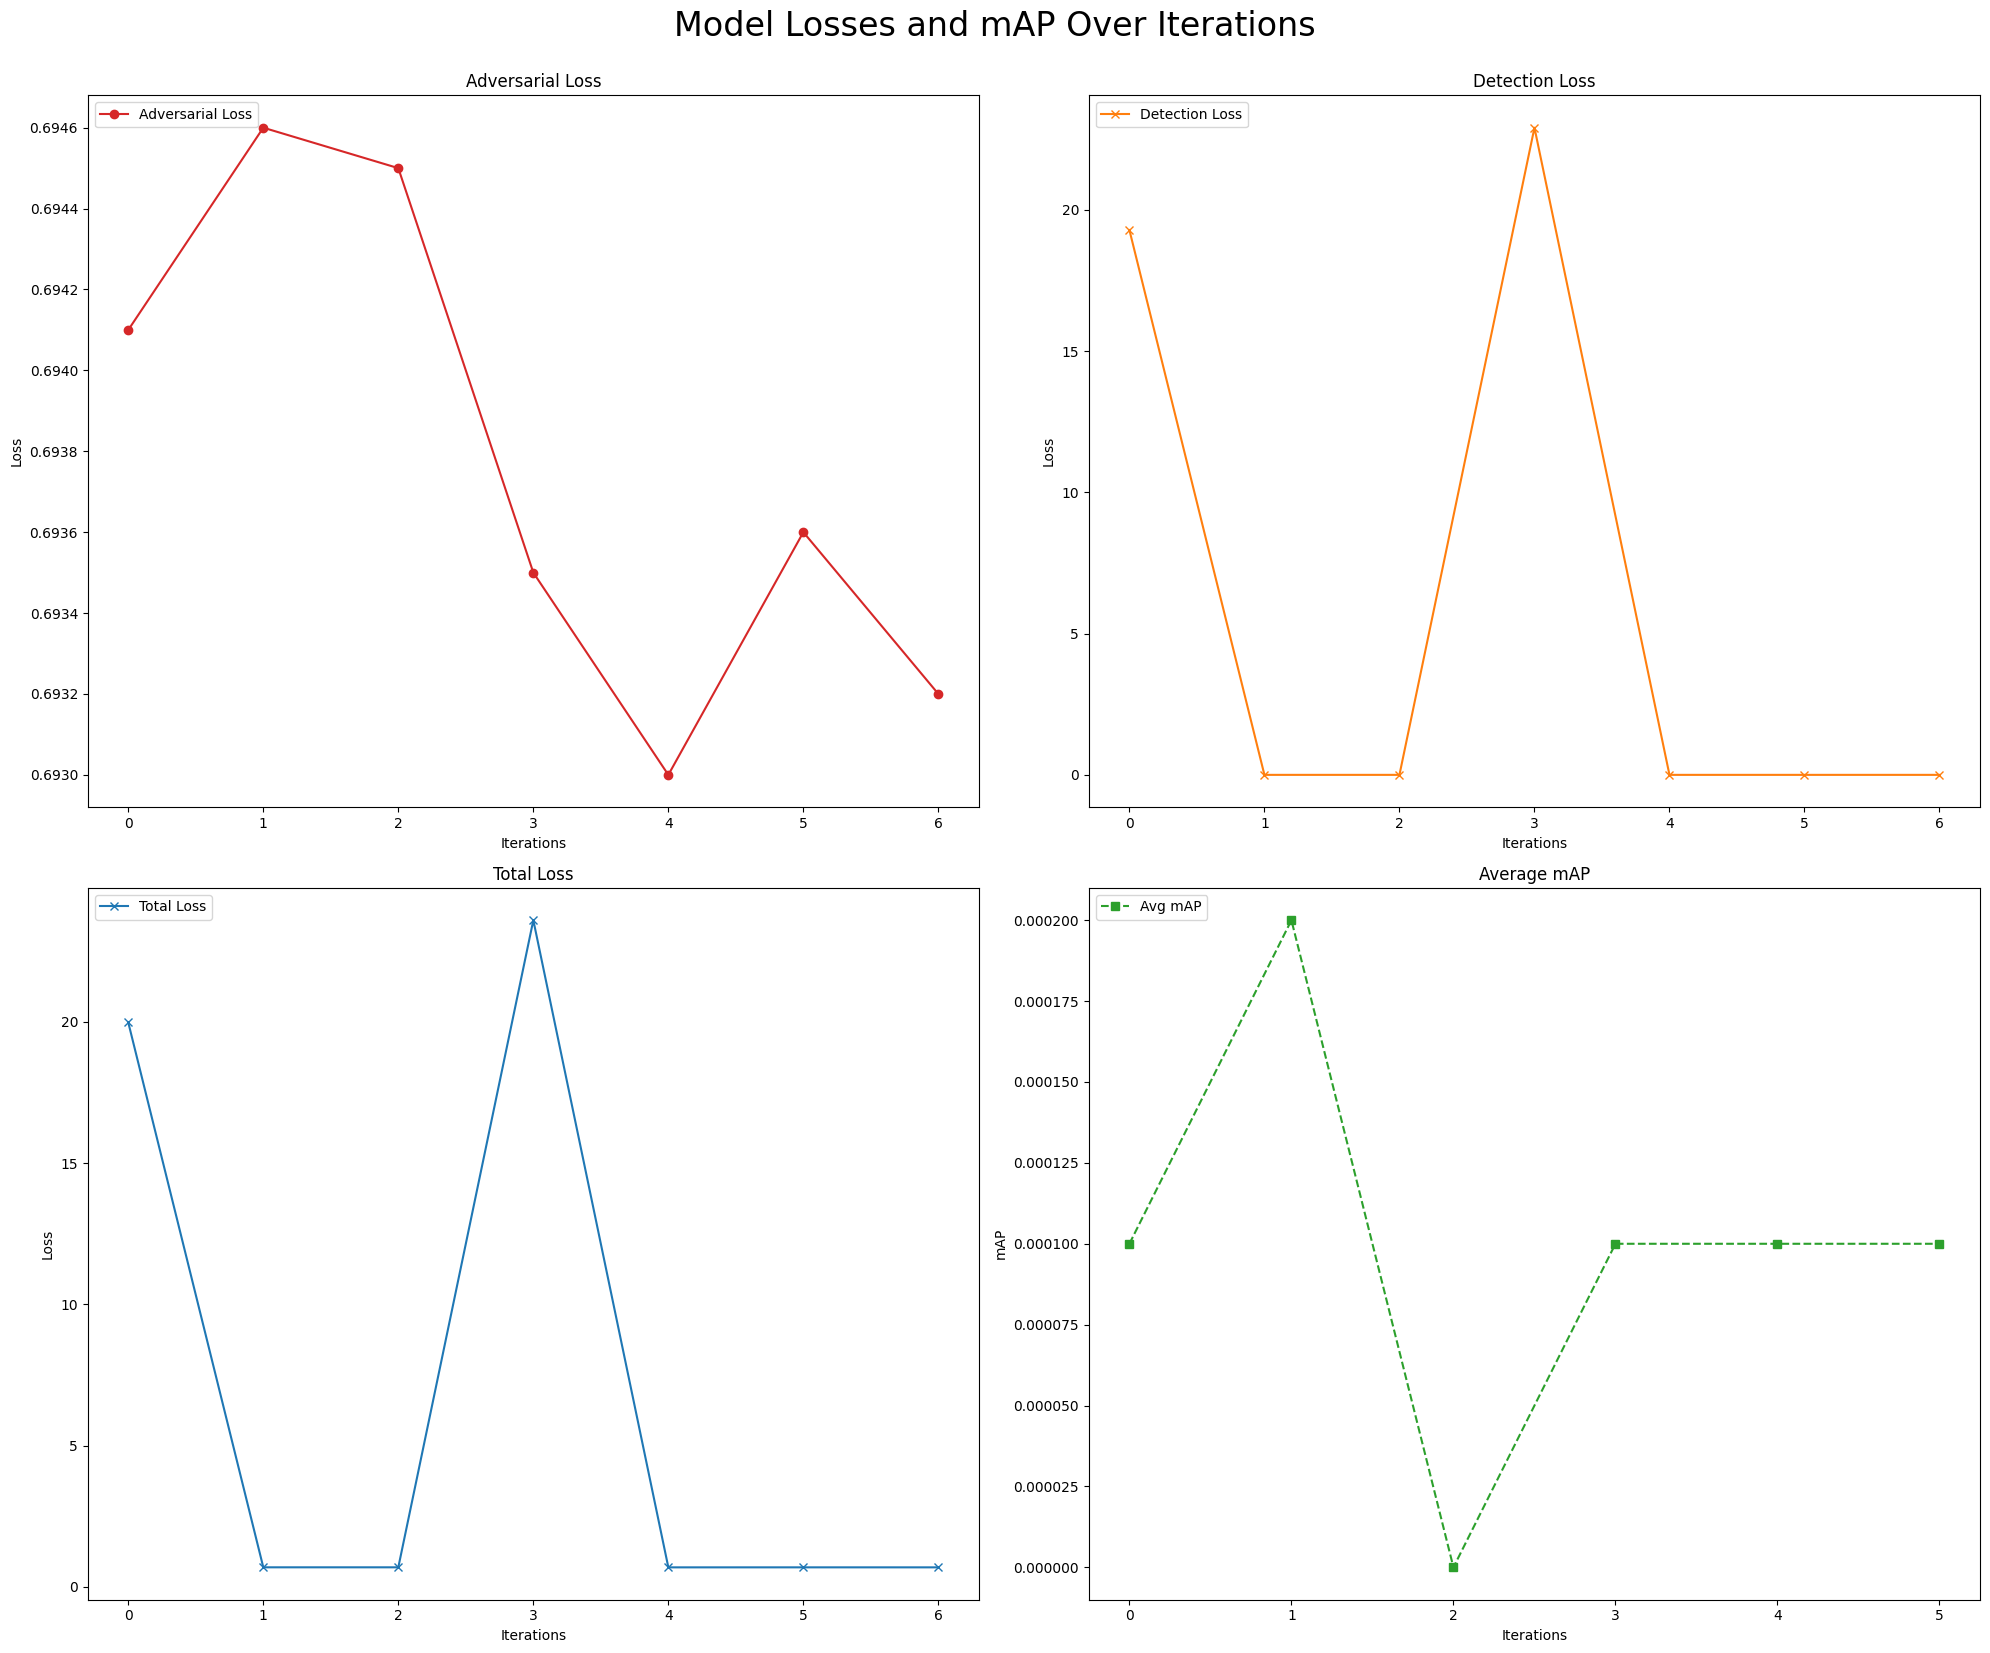

<Figure size 640x480 with 0 Axes>

In [141]:
import matplotlib.pyplot as plt

def draw_four_plots(adversarial_losses, detection_losses, total_losses, avg_map_values, title="Loss and mAP Plot", filename="losses_and_map_plot.png"):
    # Create a figure with subplots (2x2 grid)
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))

    # Plot adversarial loss
    axs[0, 0].plot(adversarial_losses, label='Adversarial Loss', color='tab:red', linestyle='-', marker='o')
    axs[0, 0].set_title('Adversarial Loss')
    axs[0, 0].set_xlabel('Iterations')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(loc='upper left')

    # Plot detection loss
    axs[0, 1].plot(detection_losses, label='Detection Loss', color='tab:orange', linestyle='-', marker='x')
    axs[0, 1].set_title('Detection Loss')
    axs[0, 1].set_xlabel('Iterations')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(loc='upper left')

    # Plot total loss
    axs[1, 0].plot(total_losses, label='Total Loss', color='tab:blue', linestyle='-', marker='x')
    axs[1, 0].set_title('Total Loss')
    axs[1, 0].set_xlabel('Iterations')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend(loc='upper left')

    # Plot avg mAP values
    axs[1, 1].plot(avg_map_values, label='Avg mAP', color='tab:green', linestyle='--', marker='s')
    axs[1, 1].set_title('Average mAP')
    axs[1, 1].set_xlabel('Iterations')
    axs[1, 1].set_ylabel('mAP')
    axs[1, 1].legend(loc='upper left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.suptitle(title, fontsize=24, y=1.03)  # Title above the plots
    plt.show()

    # Save the plot with high quality (300 DPI)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Optionally, show the plot
    plt.show()

adversarial_losses=[0.6941,0.6946,0.6945,0.6935,0.6930,0.6936,0.6932]
detection_losses=[19.2817,0.0000,0.0000,22.9029,0.0000,0.0000,0.0000]
total_losses=[19.9758,0.6946,0.6945,23.5964,0.6930,0.6936,0.6932]
avg_map_values=[0.0001,0.0002,0.0000,0.0001,0.0001,0.0001]

# Save the plot with a high-quality image
draw_four_plots(adversarial_losses, detection_losses, total_losses, avg_map_values, title="Model Losses and mAP Over Iterations", filename="losses_and_map_plot.png")


## Training Process Loss Functions Graph

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as torchtrans

def torch_to_pil(img):
    """Convert a Torch tensor image to PIL format."""
    return torchtrans.ToPILImage()(img).convert('RGB')

def plot_img_bbox(img, target, score_threshold=0.15):
    """
    Plot image with bounding boxes having scores above the threshold.

    Args:
        img (PIL.Image or Tensor): The image to display.
        target (dict): Contains 'boxes' and optionally 'scores'.
        score_threshold (float): Minimum score to display a bounding box.
    """
    # Convert image tensor to PIL if necessary
    if isinstance(img, torch.Tensor):
        img = torch_to_pil(img)

    # Create figure
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 20)
    ax.imshow(img)  # Display the image

    # Process bounding boxes and scores
    boxes = target.get('boxes', [])
    scores = target.get('scores', torch.ones(len(boxes)))  # Default to scores of 1 if not provided
    print(scores)
    for box, score in zip(boxes, scores):
        if score > score_threshold:
            x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x, y),
                                     width, height,
                                     linewidth=2,
                                     edgecolor='r',
                                     facecolor='none')

            # Draw the bounding box on top of the image
            ax.add_patch(rect)

            
    plt.show()


In [ ]:
# pick one image from the test set

img, target = next(iter(cityscapes_val_loader))
model = FasterRCNNModel(num_classes=8).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

if os.path.exists("./Model_Results/checkpoint.pth"):
    checkpoint = torch.load("./Model_Results/checkpoint.pth")
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
#print(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img[0].to(device)],targets=None)[0]
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target[0]['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img[0]), target[0])

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img[0]), prediction,score_threshold=0.2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the loss data from the CSV file
losses_df = pd.read_csv('Model_Results/Loses_info.csv')

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(losses_df['Train Loss Value'], label='Training Loss', color='blue', marker='o', linestyle='-', linewidth=2)

# Plot validation loss
plt.plot(losses_df['Validation Loss Value'], label='Validation Loss', color='red', marker='x', linestyle='--', linewidth=2)

# Adding title and labels
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
